NOM PRENOM de tous

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.arima.model import ARIMA

import plotly.express as px

In [2]:
# 1. LOADING
def load_data(file_path):
    """
    Input: file_path (str) – path to the CSV file
    Output: df (DataFrame) – loaded dataset
    """
    df = pd.read_csv(file_path)
    return df


# 2. EXPLORATION
def explore_data(df):
    """
    Prints structural information 
    and generates basic exploratory visualizations.
    """
    # Structure
    print("Dataset Shape:", df.shape)
    print("\nColumn Types:\n", df.dtypes)
    
    # Missing values
    print("\nMissing Values per Column:\n", df.isna().sum())
    
    # Basic statistics (only numeric columns)
    print("\nStatistical Summary:\n", df.describe())
    
    # Correlation matrix (if numeric data exists)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        plt.figure(figsize=(10, 6))
        sns.heatmap(df[numeric_cols].corr(), annot=False, cmap="coolwarm")
        plt.title("Correlation Heatmap")
        plt.show()
    else:
        print("\nNot enough numeric columns to compute correlations.")

In this step, we explore the structure of the dataset to understand its content. We examine:

- number of rows and columns,
- data types,
- missing values,
- numerical statistics,
- correlations between variables,
- basic visualizations (heatmap).

This information helps identify potential issues and guides the construction of the indicators in later steps.

In [8]:
# 3. INDICATORS
def indicator_groupby(df):
    """
    Indicator 1A:
        Top 10 emitting countries in 2021.
    
    Indicator 1B:
        Top 10 countries with the largest increase between 1990 and 2021.
    """

    # Indicator 1A – Top 10 emitting countries in 2021
    # Group by country and sum emissions for the year 2021
    country_emissions_2021 = (
        df.groupby("Country")["2021"]
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )

    print("Indicator 1A – Top 10 emitting countries in 2021:")
    print(country_emissions_2021)

    plt.figure(figsize=(10, 6))
    country_emissions_2021.plot(kind="bar")
    plt.title("Top 10 Emitting Countries (2021)")
    plt.ylabel("Emissions")
    plt.xlabel("Country")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Indicator 1B – Largest increase by country (1990 to 2021)
    # Select needed columns
    temp = df[["Country", "1990", "2021"]].copy()

    # Fill missing values
    temp[["1990", "2021"]] = temp[["1990", "2021"]].fillna(0)

    # Calculate the change
    temp["Change_1990_2021"] = temp["2021"] - temp["1990"]

    # Aggregate the change per country
    country_change = (
        temp.groupby("Country")["Change_1990_2021"]
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )

    print("\nIndicator 1B – Top 10 countries with the largest increase in emissions (1990–2021):")
    print(country_change)

    plt.figure(figsize=(10, 6))
    country_change.plot(kind="bar")
    plt.title("Top 10 Countries – Increase in Emissions (1990–2021)")
    plt.ylabel("Increase in emissions (2021 – 1990)")
    plt.xlabel("Country")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    pass

def indicator_transformation(df):
    """
    Indicator 2 – Data Transformation:
    K-Means clustering on standardized emission trends (1990–2021).
    """

    # Copy the data
    temp = df.copy()

    # Keep only country + year columns
    year_cols = [str(y) for y in range(1990, 2021+1)]
    temp = temp[["Country"] + year_cols]

    # Aggregate emissions by country (sum across gas/sector)
    country_data = temp.groupby("Country")[year_cols].sum()

    # Standardize emissions (important for clustering)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(country_data)

    # Apply K-means (3 clusters is a good start)
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    # Add cluster labels
    country_data["Cluster"] = clusters

    print("Indicator 2 – K-means clustering results (first 10 countries):")
    print(country_data.head(10))

    # Visualize clusters using PCA (2D projection)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    proj = pca.fit_transform(X_scaled)

    plt.figure(figsize=(10, 6))
    plt.scatter(proj[:, 0], proj[:, 1], c=clusters, cmap="viridis")
    for i, country in enumerate(country_data.index):
        plt.text(proj[i, 0], proj[i, 1], country, fontsize=8)
    plt.title("K-Means Clustering of Countries (PCA Projection)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

    return country_data

In [21]:
def indicator_temporal(df):
    """
    Indicator 3 – Temporal analysis:
    3A: ARIMA forecast of global emissions.
    3B: Linear regression trend and forecast.
    3C: Comparison of key countries (by ISO).
    """

    # Build the global time series
    # Keep only real countries: remove "World" and "European Countries"
    df_countries = df[(df["Country"] != "World") &
                      (df["Country"] != "European Countries")]

    # Select year columns
    year_cols = [str(y) for y in range(1990, 2021 + 1)]

    # Sum emissions across these countries for each year
    ts = df_countries[year_cols].sum(axis=0)

    # Index = years (as integers)
    ts.index = ts.index.astype(int)
    ts = ts.sort_index()

    # Fill missing values if there are any
    ts = ts.fillna(method="ffill").fillna(method="bfill")

    print("Global emissions time series (first values):")
    print(ts.head())
    print("\nGlobal emissions time series (last values):")
    print(ts.tail())


    # 3A – ARIMA forecast (next 10 years)
    model = ARIMA(ts, order=(1, 1, 1))  # simple ARIMA model
    results = model.fit()

    forecast_steps = 10
    forecast = results.get_forecast(steps=forecast_steps)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    last_year = ts.index.max()
    future_years = np.arange(last_year + 1, last_year + 1 + forecast_steps)

    plt.figure(figsize=(10, 6))
    plt.plot(ts.index, ts.values, label="Historical emissions")
    plt.plot(future_years, forecast_mean.values,
             label="ARIMA forecast", linestyle="--")

    plt.fill_between(
        future_years,
        forecast_ci.iloc[:, 0],
        forecast_ci.iloc[:, 1],
        alpha=0.2,
        label="95% confidence interval"
    )

    plt.title("Indicator 3 – ARIMA Forecast of Global Emissions")
    plt.xlabel("Year")
    plt.ylabel("Emissions")
    plt.legend()
    plt.tight_layout()
    plt.show()


    # 3B – Linear regression trend + prediction
    X = ts.index.values.reshape(-1, 1)   # years
    y = ts.values                        # emissions

    lin_reg = LinearRegression()
    lin_reg.fit(X, y)

    years_full = np.arange(1990, 2031)
    y_pred = lin_reg.predict(years_full.reshape(-1, 1))

    plt.figure(figsize=(10, 6))
    plt.scatter(ts.index, ts.values,
                label="Historical emissions", s=30)
    plt.plot(years_full, y_pred,
             label="Linear regression trend", linestyle="-")

    future_mask = years_full > last_year
    plt.plot(years_full[future_mask], y_pred[future_mask],
             label="Predicted (beyond historical data)", linestyle="--")

    plt.title("Indicator 3 – Linear Trend and Forecast of Global Emissions")
    plt.xlabel("Year")
    plt.ylabel("Emissions")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3C – Comparison of key countries (by ISO)
    # Clean ISO column
    df = df.copy()
    df["ISO"] = df["ISO"].str.strip()
    iso_list = ["CHN", "USA", "IND", "FRA"]

    # Year columns (adapt if your range is different)
    years = [str(y) for y in range(1990, 2021 + 1)]

    plt.figure(figsize=(10, 6))

    for iso in iso_list:
        country_df = df[df["ISO"] == iso]

        if country_df.empty:
            print(f"Warning: ISO code '{iso}' not found in the dataset.")
            continue

        # Take the first row for that ISO
        ts = country_df[years].iloc[0].values
        country_name = country_df["Country"].iloc[0]

        plt.plot(years, ts, marker="o", label=country_name)

    plt.title("Indicator 3 – Comparison of Emissions for Selected Countries")
    plt.xlabel("Year")
    plt.ylabel("Emissions")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    pass

#### **Indicator 3A — ARIMA Forecast of Global Emissions**

In this indicator, we construct a global time series by summing emissions from all individual countries (excluding aggregate entries such as "World" or "European Countries").
We then apply an ARIMA (1,1,1) model to the historical emissions from 1990 to 2021 to forecast the next ten years.

The resulting plot includes:

* the historical emissions curve,
* the ARIMA forecast (dashed line),
* a 95% confidence interval.

This indicator provides a data-driven projection of global emissions if past long-term dynamics continue. It also illustrates the uncertainty inherent in forecasting environmental variables over time.

#### **Indicator 3B — Linear Trend and Forecast of Global Emissions**

In parallel with ARIMA, we fit a simple linear regression model to the same global emission time series.
This model captures the long-term linear trend between emissions and time and is then used to predict emissions up to 2030.

The plot shows:

* historical emissions (scatter points),
* the fitted linear trend line,
* future predicted emissions (dashed line).

This indicator offers a simplified but intuitive forecast of emissions. Comparing it with the ARIMA forecast helps illustrate differences between linear and statistical time-series models.


#### **Indicator 3C — Comparison of Emission Trends for Selected Countries**

To complement the global analysis, we compare the emission trajectories of several major countries over the same period (1990–2021).
For each selected ISO code, we extract the country’s time series and plot them together on a single graph.

This comparison reveals meaningful differences between countries:

* some exhibit fast-growing emissions,
* others show moderate growth or stabilization,
* a few display declining emissions over time.

This indicator provides important context by showing how national trajectories differ from the global trend and from one another.

In [20]:
def indicator_spatial(df):
    """
    Indicator 4 – Spatial analysis.

    4A: Share of global emissions (%) by country in 2021.
    4B: Emission Trend Slopebetween 1990 and 2021 by country.
    """

    # Common: clean and keep real countries only
    df_countries = df.copy()
    df_countries["ISO"] = df_countries["ISO"].str.strip()
    df_countries["Country"] = df_countries["Country"].str.strip()

    # Remove aggregate rows that are not individual countries
    df_countries = df_countries[
        (df_countries["Country"] != "World") &
        (df_countries["Country"] != "European Countries")
    ]

    # 4A – Share of global emissions (%) in 2021
    emissions_2021 = (
        df_countries.groupby(["ISO", "Country"])["2021"]
        .sum()
        .reset_index()
    )

    total_2021 = emissions_2021["2021"].sum()
    emissions_2021["Share_2021"] = emissions_2021["2021"] / total_2021 * 100

    fig_share = px.choropleth(
        emissions_2021,
        locations="ISO",
        color="Share_2021",
        hover_name="Country",
        hover_data={"2021": True, "Share_2021": ":.2f"},
        color_continuous_scale="Reds",
        labels={"Share_2021": "Share of global emissions (%)"},
        title="Indicator 4A – Share of Global Emissions by Country (2021)"
    )
    fig_share.show()

    # 4B – Trend Slope of Emissions (1990–2021)
    # Compute slope for each country
    slopes = []
    df_temp = df.copy()
    df_temp["ISO"] = df_temp["ISO"].str.strip()
    df_temp["Country"] = df_temp["Country"].str.strip()

    # Remove aggregate rows
    df_temp = df_temp[
        (df_temp["Country"] != "World") &
        (df_temp["Country"] != "European Countries")
    ]

    years = [str(y) for y in range(1990, 2021 + 1)]
    X = np.array([int(y) for y in years]).reshape(-1, 1)

    for iso, g in df_temp.groupby("ISO"):
        y_vals = g[years].sum().values
        
        if np.all(np.isnan(y_vals)):
            continue
        
        y_vals = np.nan_to_num(y_vals)

        model = LinearRegression().fit(X, y_vals)
        slope = model.coef_[0]

        slopes.append({
            "ISO": iso,
            "Country": g["Country"].iloc[0],
            "Slope": slope
        })

    slopes_df = pd.DataFrame(slopes)
    # Clip extreme slopes to avoid China/India dominating visually
    slopes_df["Slope_clipped"] = slopes_df["Slope"].clip(
        lower=slopes_df["Slope"].quantile(0.05),
        upper=slopes_df["Slope"].quantile(0.95)
    )

    fig_slope = px.choropleth(
        slopes_df,
        locations="ISO",
        color="Slope_clipped",
        hover_name="Country",
        hover_data={"Slope": ":.2f"},
        # Much stronger contrast
        color_continuous_scale=[
            (0.00, "#2B1F5C"),
            (0.25, "#4B74C8"),
            (0.50, "#E8E8E8"),
            (0.75, "#F97B22"),
            (1.00, "#7A0403")
        ],
        color_continuous_midpoint=0,
        labels={"Slope_clipped": "Trend slope (1990–2021)"},
        title="Indicator 4 – Emission Trend Slope by Country (1990–2021)"
    )

    fig_slope.update_layout(
        coloraxis_colorbar=dict(
            title="Slope",
            tickformat=".2f"
        )
    )

    fig_slope.show()
    pass

#### **Indicator 4A – Share of global emissions by country (2021)**

Instead of plotting raw emissions, we compute for each country its **share of global emissions in 2021**.
We first aggregate emissions per country and then divide by the world total to obtain a percentage.
The choropleth map highlights:

* a small number of countries concentrating a very large share of global emissions,
* many countries with a very small contribution in absolute terms.

This indicator is more informative than raw values, as it directly answers the question:
**“Which countries contribute the most to global emissions?”**


#### **Indicator 4B — Emission Trend Slope (1990–2021)**

For each country, we compute a linear regression of annual greenhouse gas emissions from 1990 to 2021.

**Formula** : Emissions = *a* x Year + *b*

**Interpretation of the slope (the coefficient "a"):**

* **Slope > 0** → emissions are increasing
* **Slope < 0** → emissions are decreasing
* **Slope ≈ 0** → emissions are relatively stable

This indicator highlights long-term emission dynamics at the country level.
It reveals three important patterns:

1. **Fast-growing emitters** (large positive slopes), often rapidly industrializing economies
2. **Stabilizing or slowly increasing countries**
3. **Countries with declining emissions** (negative slopes), usually due to climate policies or economic restructuring

This spatial visualization complements the global ARIMA and linear regression indicators by showing **where** emission trajectories are rising or falling across the world.

In [4]:
# 4. DASHBOARD
def create_dashboard():
    """
    Creates and launches the Dash dashboard.
    """
    pass

C:\Users\bella\AppData\Local\Temp\ipykernel_32332\218799559.py:25: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

c:\Users\bella\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\bella\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\bella\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for for

Global emissions time series (first values):
1990    35837.11
1991    35927.29
1992    35779.41
1993    35855.08
1994    36095.38
dtype: float64

Global emissions time series (last values):
2017    50053.10
2018    51090.80
2019    51324.37
2020    49074.10
2021    51285.43
dtype: float64


c:\Users\bella\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\bella\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



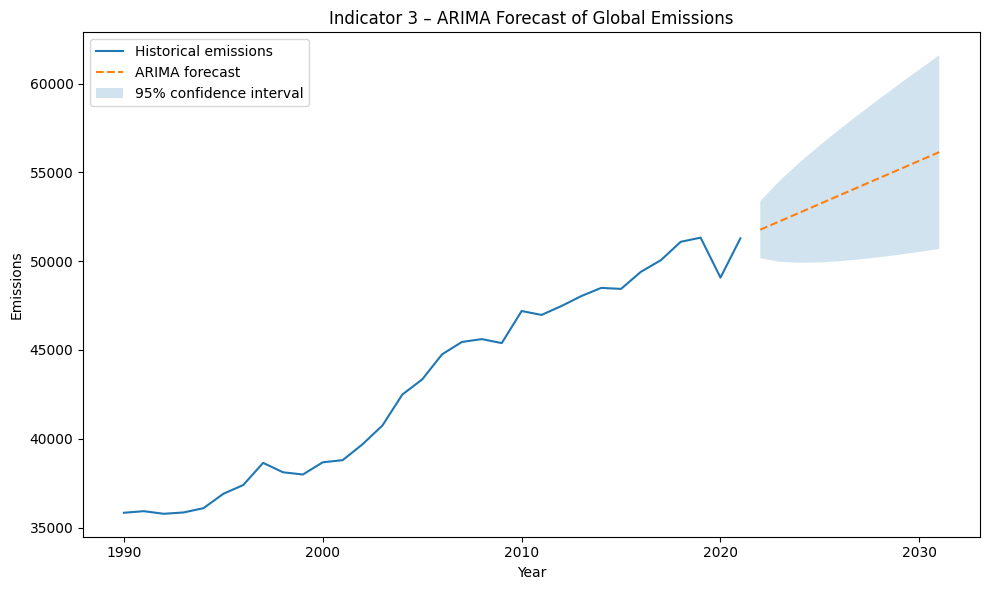

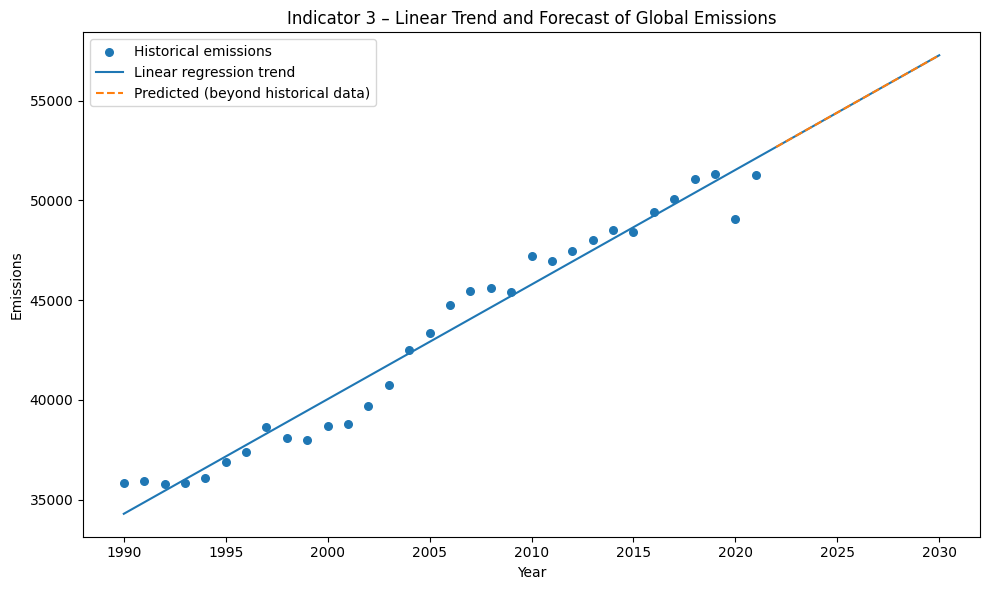

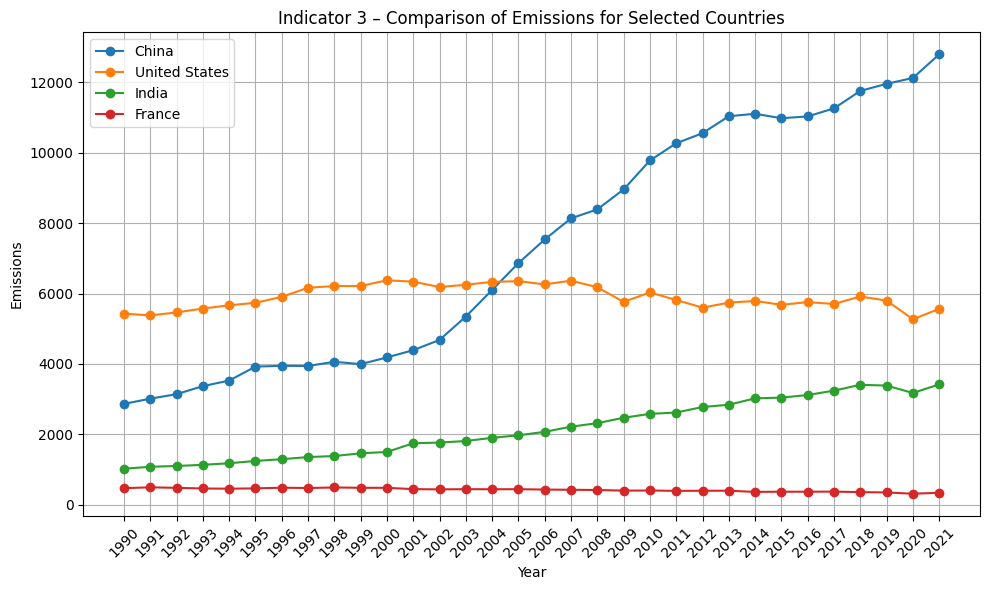

In [22]:
# 5. MAIN FUNCTION
def main():
    file_path = "historical_emissions.csv"
    
    # Step 1: Load the data
    df = load_data(file_path)
    
    # Step 2: Explore the data
    # explore_data(df)
    
    # Step 3: Build the indicators
    # indicator_groupby(df)
    # indicator_transformation(df)
    indicator_temporal(df)
    indicator_spatial(df)
    
    # Step 4: Launch the dashboard
    create_dashboard()


if __name__ == "__main__":
    main()